# MNIST Denoising with From-Scratch CNN (NumPy only)

This notebook:
- Uses the provided `DataGenerator` to load and normalize MNIST.
- Adds synthetic noise to images to create a denoising task.
- Implements a small fully-convolutional autoencoder **from scratch with NumPy**.
- Trains with MSE loss and visualizes denoised outputs.



In [45]:
import numpy as np
from data_generator import DataGenerator

dg = DataGenerator(verbose=True)
dg.generate(dataset="mnist", N_train=5000, N_valid=0.1)

# Clean targets (image-to-image target)
y_train = dg.x_train
y_valid = dg.x_valid

# Create noisy inputs
rng = np.random.RandomState(0)
sigma = 0.25  # noise strength; try 0.15–0.35

x_train = np.clip(y_train + sigma * rng.randn(*y_train.shape).astype(np.float32), -1.0, 1.0)
x_valid = np.clip(y_valid + sigma * rng.randn(*y_valid.shape).astype(np.float32), -1.0, 1.0)

print("x_train:", x_train.shape, x_train.min(), x_train.max())
print("y_train:", y_train.shape, y_train.min(), y_train.max())


Data specification:
	Dataset type:           mnist
	Number of classes:      10
	Number of channels:     1
	Training data shape:    (5000, 28, 28, 1)
	Validation data shape:  (6000, 28, 28, 1)
	Test data shape:        (10000, 28, 28, 1)
x_train: (5000, 28, 28, 1) -1.0 1.0
y_train: (5000, 28, 28, 1) -1.0 1.0


In [46]:
import importlib
import cnn
importlib.reload(cnn)

from cnn import CNN, init_deep_image_to_image_cnn

input_shape = x_train.shape[1:]  # (28, 28, 1) for MNIST
W_list, b_list, lname = init_deep_image_to_image_cnn(
    input_shape=x_train.shape[1:],
    num_filters = (8, 16, 8),          # two conv layers
)

model = CNN(dataset=dg, verbose=True)
model.setup_model(W_list, b_list, lname, activation="relu")


CNN model set up with layers:
  Layer 0: conv, W shape: (3, 3, 1, 8)
  Layer 1: conv, W shape: (3, 3, 8, 16)
  Layer 2: conv, W shape: (3, 3, 16, 8)
  Layer 3: conv_out, W shape: (3, 3, 8, 1)


In [47]:
history1 = model.fit(x_train, y_train, epochs=5, batch_size=64, lr=1e-3, clip_grad=1.0,
                     x_val=x_valid, y_val=y_valid)

# Second half of training with lower learning rate
history2 = model.fit(x_train, y_train, epochs=5, batch_size=64, lr=5e-4, clip_grad=1.0,
                     x_val=x_valid, y_val=y_valid)


Epoch 1/5 [=========================>] 100%  batch_loss=3.0542e-01  avg_loss=3.8847e-01
           val_loss=2.8906e-01  psnr=5.39 dB
Epoch 2/5 [=========================>] 100%  batch_loss=2.2974e-01  avg_loss=2.5075e-01
           val_loss=2.2094e-01  psnr=6.56 dB
Epoch 3/5 [=========================>] 100%  batch_loss=1.7993e-01  avg_loss=2.0277e-01
           val_loss=1.8728e-01  psnr=7.28 dB
Epoch 4/5 [=========================>] 100%  batch_loss=1.6450e-01  avg_loss=1.7583e-01
           val_loss=1.6553e-01  psnr=7.81 dB
Epoch 5/5 [=========================>] 100%  batch_loss=1.4446e-01  avg_loss=1.5713e-01
           val_loss=1.4954e-01  psnr=8.25 dB
Epoch 1/5 [=========================>] 100%  batch_loss=1.4796e-01  avg_loss=1.4615e-01
           val_loss=1.4292e-01  psnr=8.45 dB
Epoch 2/5 [=========================>] 100%  batch_loss=1.4182e-01  avg_loss=1.3988e-01
           val_loss=1.3701e-01  psnr=8.63 dB
Epoch 3/5 [=========================>] 100%  batch_loss=1.2576e-01  a

In [49]:
stats = model.evaluate(x_valid[:128], y_valid[:128], metric="mse")
print("Valid MSE:", stats)

stats_psnr = model.evaluate(x_valid[:128], y_valid[:128], metric="psnr", max_val=1.0)
print("Valid PSNR:", stats_psnr)


Valid MSE: {'loss': 0.1246822401881218}
Valid PSNR: {'loss': 0.1246822401881218, 'psnr': 9.041953684463195}


## Visual validation

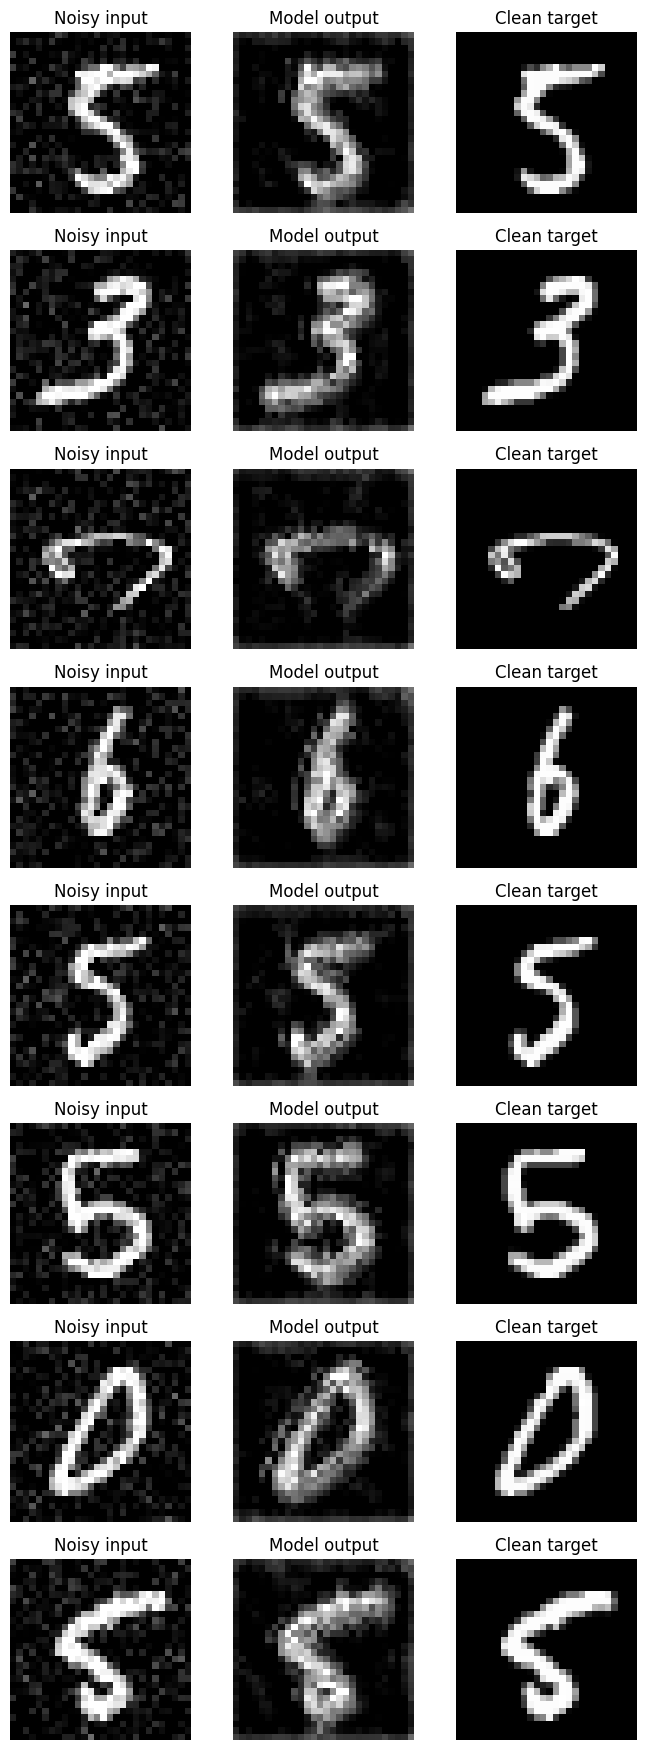

Per-sample MSE: [0.09350967 0.13518484 0.07009964 0.15307577 0.09900889 0.07147729
 0.15325946 0.11017657]


In [50]:
import numpy as np
import matplotlib.pyplot as plt

def show_denoising_triplets(model, x_noisy, y_clean, n=8, seed=0):
    rng = np.random.RandomState(seed)
    idx = rng.choice(x_noisy.shape[0], size=n, replace=False)

    x_in = x_noisy[idx]
    y_gt = y_clean[idx]
    y_hat = model.feedforward(x_in)   # shape (n, H, W, C)

    # map from [-1,1] -> [0,1] for display (safe even if already [0,1])
    def to01(a):
        a = (a + 1.0) / 2.0
        return np.clip(a, 0.0, 1.0)

    x_disp = to01(x_in)
    yhat_disp = to01(y_hat)
    ygt_disp = to01(y_gt)

    fig, axes = plt.subplots(n, 3, figsize=(7, 2.2*n))
    titles = ["Noisy input", "Model output", "Clean target"]

    for row in range(n):
        for col, img in enumerate([x_disp[row], yhat_disp[row], ygt_disp[row]]):
            ax = axes[row, col] if n > 1 else axes[col]
            ax.set_title(titles[col])
            ax.axis("off")

            # grayscale vs RGB
            if img.shape[-1] == 1:
                ax.imshow(img[..., 0], cmap="gray", vmin=0, vmax=1)
            else:
                ax.imshow(img, vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

# Example usage:
show_denoising_triplets(model, x_valid, y_valid, n=8, seed=1)

idx = np.arange(8)
pred = model.feedforward(x_valid[idx])
per_sample_mse = np.mean((pred - y_valid[idx])**2, axis=(1,2,3))
print("Per-sample MSE:", per_sample_mse)

